# Nested Sampling with `dynesty`: The Basics

This is a simple interactive demo that briefly goes over nested sampling and some of the features available in `dynesty`. See the [documentation](dynesty.readthedocs.io) for more details.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
rstate = np.random.default_rng(5647)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

# Demonstration on 3-D Correlated Multivariate Normal

Let's get a sense for how `dynesty` works using a strongly correlated 3-D **multivariate Normal** distribution.

In [3]:
import dynesty

In [4]:
ndim = 3  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

As described in the documentation, `dynesty` samples over the unit cube. We'll define our prior (via `prior_transform`) to be uniform in each dimension from -10 to 10 and 0 everywhere else.

In [5]:
# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -10. and 10. in each variable."""
    return 10. * (2. * u - 1.)

Finally, `dynesty` can also incorporate gradients when sampling, provided they are properly defined *with respect to the unit cube*. An example is shown below.

In [6]:
# gradient of log-likelihood *with respect to u*
# -> d(lnl)/du = d(lnl)/dv * dv/du
# dv/du = 1. / prior(v)
def gradient(x):
    """Multivariate normal log-likelihood gradient."""
    dlnl_dv = -np.dot(Cinv, x)  # standard gradient
    jac = np.diag(np.full_like(x, 20.))  # Jacobian
    return np.dot(jac, dlnl_dv)  # transformed gradient

## Sampling the Target Distribution

Let's now initialize our nested sampler. We'll use $K=1500$ live points (rather than the default $K=500$) along with `dynesty`'s default bounding/sampling modes.

In [7]:
# initialize our nested sampler
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, nlive=1500,
                               rstate=rstate)

### Sampling Internally

We can now begin sampling from our target distribution. `NestedSampler` is designed for evidence estimation (posteriors are a nice byproduct), so the stopping criteria defaults to $\Delta \ln \hat{\mathcal{Z}}_i < 0.005 (K+1)$ if we intend to "recycle" the final set of live points (`add_live=True`; this is the default behavior) and $\Delta \ln \hat{\mathcal{Z}}_i < 0.01$ otherwise.

In [8]:
# sample from the target distribution
sampler.run_nested()

12595it [00:12, 998.53it/s, +1500 | bound: 6 | nc: 1 | ncall: 68107 | eff(%): 21.161 | loglstar:   -inf < -0.302 <    inf | logz: -8.999 +/-  0.082 | dlogz:  0.001 >  1.509]


### Results

The results can be accessed after a run via `sampler.results` and are stored as a modified dictionary. We can get a quick summary of our results using the `summary()` method, although the actual file contains a host of information about the nested sampling run.

In [9]:
res = sampler.results  # grab our results
print('Keys:', res.keys(),'\n')  # print accessible keys
res.summary()  # print a summary

Keys: ['nlive', 'niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_it', 'samples_u', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale'] 

Summary
nlive: 1500
niter: 12595
ncall: 66607
eff(%): 21.161
logz: -8.999 +/-  0.215


The most relevant quantities for a general user will be **`samples`** (the collection of samples from the run), **`logwt`** (their corresponding ln-importance weights), **`logz`** (the cumulative ln-evidence), and **`logzerr`** (the error on the ln-evidence). The remaining quantities are used to help visualize the output (see below) and will also be useful for more advanced users who want additional information about the nested sampling run. See the documentation for more detailed information.

## Extending a Run

Let's see if we can do any better by adding more samples (dead points) until an even more stringent stopping criterion is met. By default, `dynesty` keeps track of the live points and final set of samples, making it easy to add additional samples to the same run.

In [10]:
sampler.run_nested(dlogz=0.1)

16577it [00:03, 4265.88it/s, +1500 | bound: 9 | nc: 1 | ncall: 74935 | eff(%): 24.616 | loglstar:   -inf < -0.294 <    inf | logz: -9.002 +/-  0.067 | dlogz:  0.000 >  0.100]


### Sampling Externally

In addition to having our samples generated entirely internally to our `NestedSampler` object via `run_nested()`, `dynesty` can also be run explicitly as a **generator** using the `sample()` option.

In [11]:
dlogz_final = 0.01

from dynesty.results import print_fn

# continue sampling from where we left off
ncall = sampler.ncall  # internal calls
nit = sampler.it  # internal iteration
for it, results in enumerate(sampler.sample(dlogz=dlogz_final)):
    # split up our results
    (worst, ustar, vstar, loglstar, logvol, logwt, logz, logzvar,
     h, nc, worst_it, boundidx, bounditer, eff, delta_logz) = results
    # add number of function calls
    ncall += nc
    nit += 1
    # print results
    print_fn(results, nit, ncall, dlogz=dlogz_final)

# add the remaining live points back into our final results 
# (they are removed from our set of dead points each time we start sampling)
for it2, results in enumerate(sampler.add_live_points()):
    # split up results
    (worst, ustar, vstar, loglstar, logvol, logwt, logz, logzvar,
     h, nc, worst_it, boundidx, bounditer, eff, delta_logz) = results
    # print results
    print_fn(results, nit, ncall, add_live_it=it2+1, dlogz=dlogz_final)

res2 = sampler.results

iter: 19986 | +1500 | bound: 12 | nc: 1 | ncall: 79413 | eff(%): 27.055 | loglstar:   -inf < -0.294 <    inf | logz: -9.002 +/-  0.067 | dlogz:  0.000 >  0.010                                       

At this point, note that our estimated evidence $\ln \mathcal{Z}_i$ from our original run (`res`) and this extended run (`res2`) are almost identical even though we've almost doubled the total number of samples, although the effective error is somewhat smaller. This demonstrates how much we can gain by "recycling" the final set of live points.

# Sampling in Parallel

`dynesty` supports evaluating likelihood functions in parallel through a user-provided `pool`. The only requirements are that the pool has a `map` function and supports advanced pickling (via `dill` or `cloudpickle`) to facilitate passing nested function calls.

We will use the excellent **[`ipyparallel`](https://ipyparallel.readthedocs.io/en/latest/)** package to support our parallelization. In this particular example, the underlying cluster is also running the [MPICH](http://www.mpich.org/) implementation of [MPI](https://en.wikipedia.org/wiki/Message_Passing_Interface). See the [`ipyparallel` documentation](https://ipyparallel.readthedocs.io/en/latest/) for additional information on getting set up.

In [12]:
import ipyparallel as ipp

In [13]:
cl = ipp.Cluster(n=4)


Once we have `ipyparallel` imported and a cluster up and running, we need to create a "client" to interface with our processors.

In [14]:
rc=cl.start_and_connect_sync()
nprocs = len(rc.ids)
print(rc.ids)

Starting 4 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

[0, 1, 2, 3]


To enable direct execution, we will then make used of a `DirectView` object and set it to use `dill` instead of the default `pickle`. This helps to avoid some pickling issues that can arise when transferring information to members of the `pool`.

In [15]:
dview = rc[:]
dview.use_dill();

Although our processors have now been initialized, they do not share global memory. We now need to initialize each member of the group with the same global environment. This can be done using the `%%px` magic function, which automatically runs all commands below it in the same cell in parallel.

In [16]:
%%px

# import environment
from __future__ import division, print_function
from six.moves import range
import time, sys, os
import numpy as np
from numpy import linalg
import dynesty

# define likelihood constants
ndim = 3
C = np.identity(ndim)
C[C==0] = 0.95
Cinv = linalg.inv(C)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))

# seed the random number generator
np.random.seed(os.getpid())
print('Random seed:',os.getpid())

[stdout:0] Random seed: 1016504


[stdout:2] Random seed: 1016510


[stdout:1] Random seed: 1016507


[stdout:3] Random seed: 1016513


The final step is to create an appropriate `pool`. By default, `dview.map` aliases an *asynchronous* map whose results can be accessed afterwards. We, however, require a simpler, *synchronous* `map` that just returns the results of the distributed computation in one batch. This just requires wrapping the `dview.map_sync` function.

In [17]:
class Pool(object):
    """A simple wrapper for `dview`."""
    
    def __init__(self, dview):
        self.dview = dview
        self.size = nprocs
        
    def map(self, function, tasks):
        return self.dview.map_sync(function, tasks)

# define our pool
pool = Pool(dview)

With that, our pool is all set! By default, `dynesty` will use our pool to compute most bulk operations in parallel. For illustrative purposes, here we'll opt to do perform ellipsoid decompositions in serial by specifying the appropriate `use_pool` flag. We'll also switch sampling methods to `'hslice'` to illustrate how `dynesty` can use gradients to generate new live points with "Hamiltonian" slice sampling. Finally, we'll change the bounding/sampling behavior by tweaking the `first_update` argument to illustrate that behavior.

In [18]:
psampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, 
                                 nlive=1500, sample='hslice', gradient=gradient,
                                 first_update={'min_ncall': 5000, 'min_eff': 50.},
                                 pool=pool, use_pool={'update_bound': False},
                                rstate=rstate)

In [19]:
psampler.run_nested(dlogz=0.01)
pres = psampler.results

19800it [03:36, 91.39it/s, +1500 | bound: 70 | nc: 1 | ncall: 15571926 | eff(%):  0.137 | loglstar:   -inf < -0.294 <    inf | logz: -8.879 +/-  0.069 | dlogz:  0.000 >  0.010]


# Results

Let's see how we did!

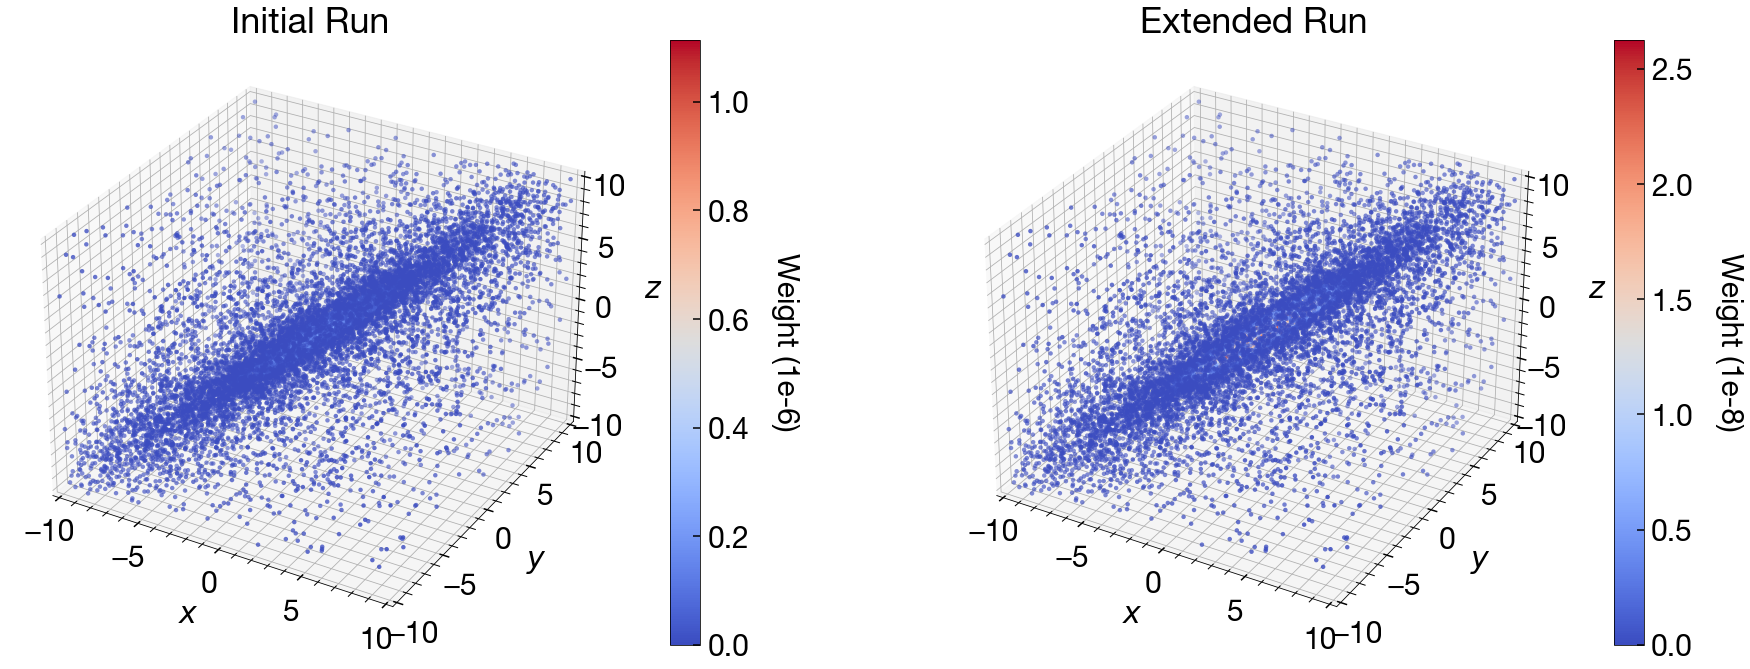

In [20]:
# 3-D plots of position and likelihood, colored by weight
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(121, projection='3d')

# plotting the initial run
p = ax.scatter(res.samples[:, 0], res.samples[:, 1], res.samples[:, 2],
               marker='o', c=np.exp(res.logwt) * 1e7, linewidths=(0.,), cmap='coolwarm')
ax.set_xlim(-10., 10.)
ax.set_xticks(np.linspace(-10., 10., 5))
ax.set_xlabel(r'$x$', labelpad=25)
ax.set_ylim(-10., 10.)
ax.set_yticks(np.linspace(-10., 10., 5))
ax.set_ylabel(r'$y$', labelpad=25)
ax.set_zlim(-10., 10.)
ax.set_zticks(np.linspace(-10., 10., 5))
ax.set_zlabel(r'$z$', labelpad=25)
ax.set_title('Initial Run')
cb = fig.colorbar(p)
cb.set_label('Weight (1e-6)', labelpad=50., rotation=270.)
plt.tight_layout()

# plotting the extended run
ax = fig.add_subplot(122, projection='3d')
p = ax.scatter(res2.samples[:, 0], res2.samples[:, 1], res2.samples[:, 2],
               marker='o', c=np.exp(res2.logwt) * 1e8, linewidths=(0.,), cmap='coolwarm')
ax.set_xlim(-10., 10.)
ax.set_xticks(np.linspace(-10., 10., 5))
ax.set_xlabel(r'$x$', labelpad=25)
ax.set_ylim(-10., 10.)
ax.set_yticks(np.linspace(-10., 10., 5))
ax.set_ylabel(r'$y$', labelpad=25)
ax.set_zlim(-10., 10.)
ax.set_zticks(np.linspace(-10., 10., 5))
ax.set_zlabel(r'$z$', labelpad=25)
ax.set_title('Extended Run')
cb = fig.colorbar(p)
cb.set_label('Weight (1e-8)', labelpad=50., rotation=270.)
plt.tight_layout()

# Visualizing Outputs

We can take a more detailed look at what our nested sampler is doing over the course of our run using several of `dynesty`'s built-in plotting utilities.

In [21]:
from dynesty import plotting as dyplot

## Summary Plots

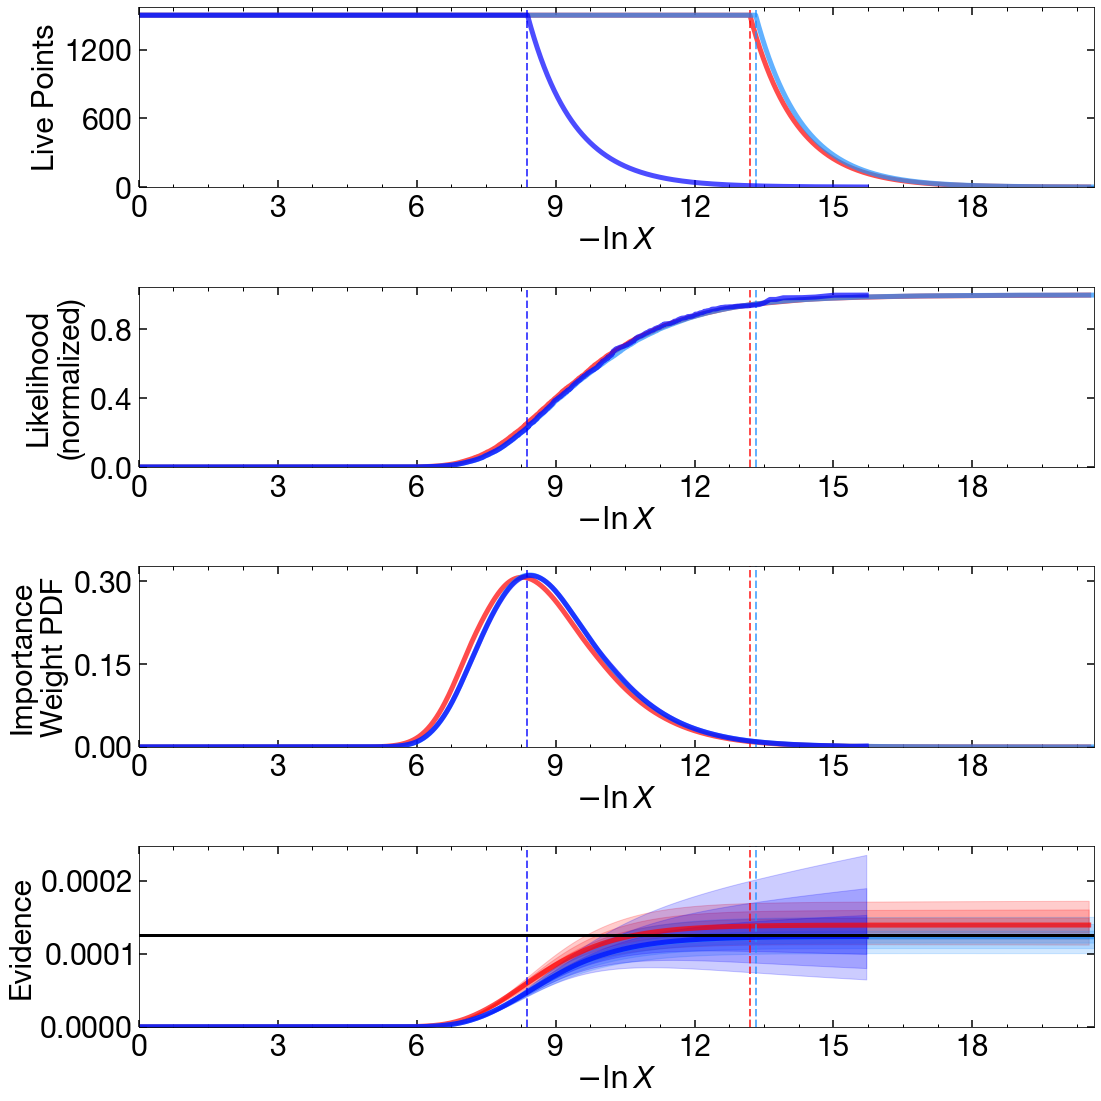

In [22]:
# analytic evidence solution
lnz_truth = ndim * -np.log(2 * 10.)  # log(volume) of prior; log(like) is normalized

# plot parallel run
fig, axes = dyplot.runplot(pres, color='red')

# plot extended run
fig, axes = dyplot.runplot(res2, color='dodgerblue', fig=(fig, axes))

# overplot original run
fig, axes = dyplot.runplot(res, color='blue', lnz_truth=lnz_truth, truth_color='black',
                           fig=(fig, axes))
fig.tight_layout()

We see that up until we recycle our final set of live points (indicated by the dashed lines), the number of live points is constant as a function of $\ln X_i$. Afterwards, however, it flattens out, rapidly traversing the remaining prior volume in linear fashion. While this clearly introduces additional sampling noise, the overall effect on $\ln \hat{\mathcal{Z}}$ itself is quite muted (especially given the estimated uncertainties).

## Traces and Posteriors

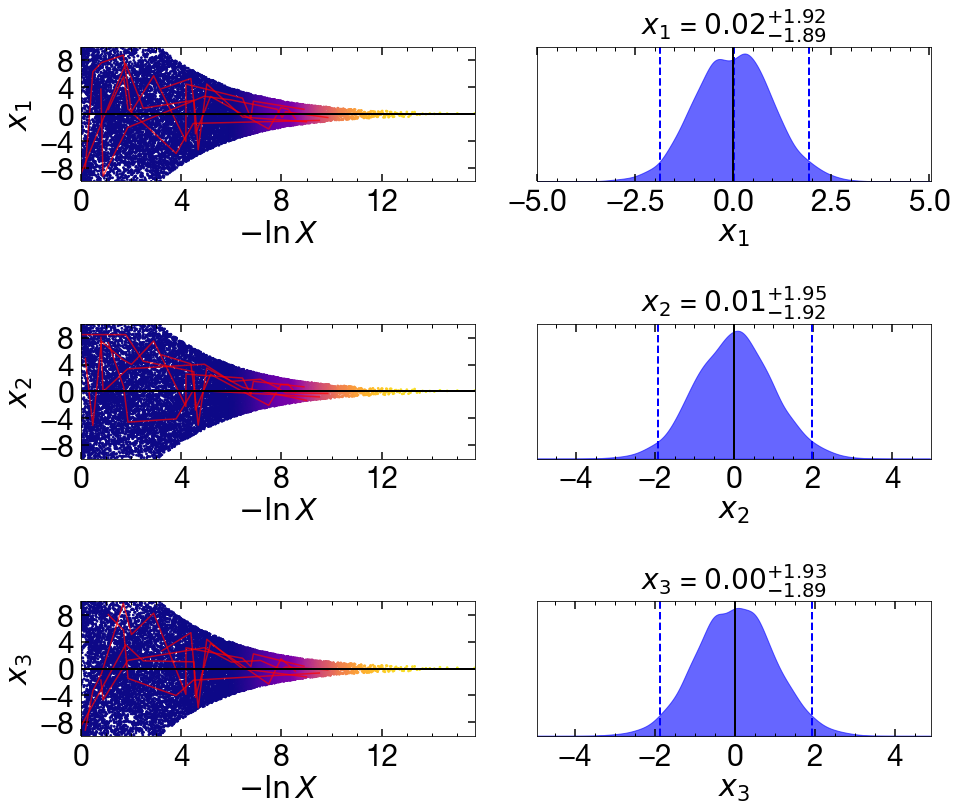

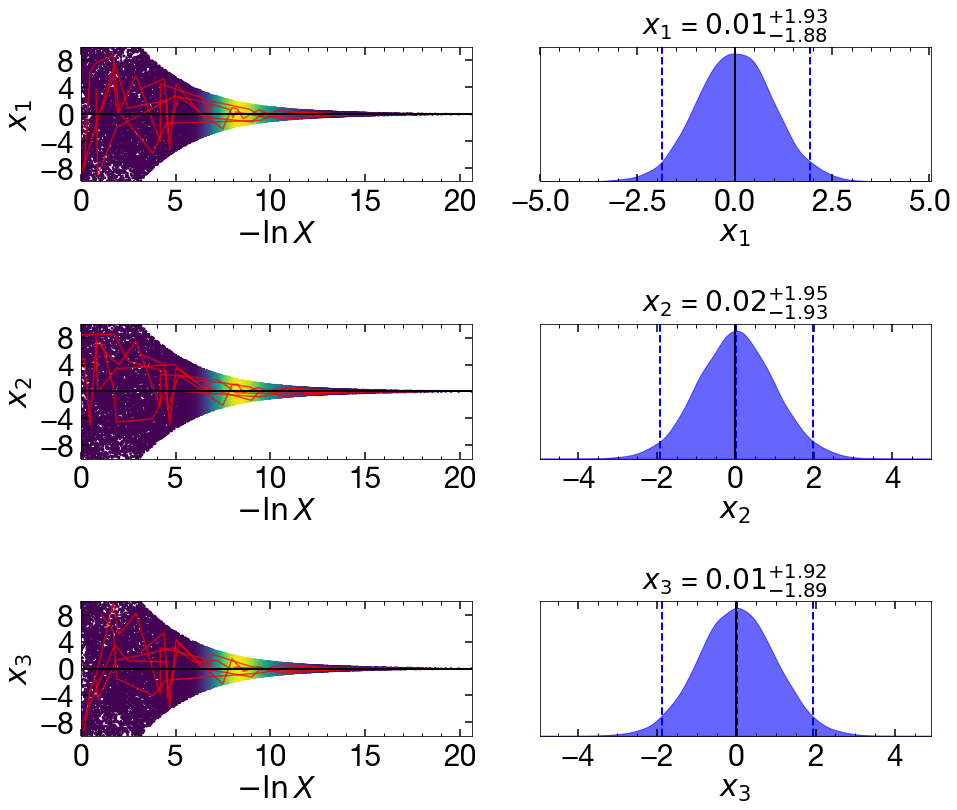

In [23]:
# plotting the original run
fig, axes = dyplot.traceplot(res, truths=[0., 0., 0.], truth_color='black',
                             show_titles=True, title_kwargs={'fontsize': 28, 'y': 1.05},
                             trace_cmap='plasma', kde=False,
                             connect=True, connect_highlight=range(5),
                             fig=plt.subplots(3, 2, figsize=(14, 12)))
fig.tight_layout()

# plotting the continued run
fig, axes = dyplot.traceplot(res2, truths=[0., 0., 0.], truth_color='black',
                             show_titles=True, title_kwargs={'fontsize': 28, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5),
                             fig=plt.subplots(3, 2, figsize=(14, 12)))
fig.tight_layout()

We see that although the evidences we estimate from both runs are almost identical, the (marginalized) posteriors we derive in our extended run is considerably smoother since we have more finely sampled the bulk of the posterior mass (clearly visible in the bottom three left panels).

## Corner Plots

Let's first take a look at the positions and weights of our individual samples to see where our samples are concentrated using `cornerpoints`.

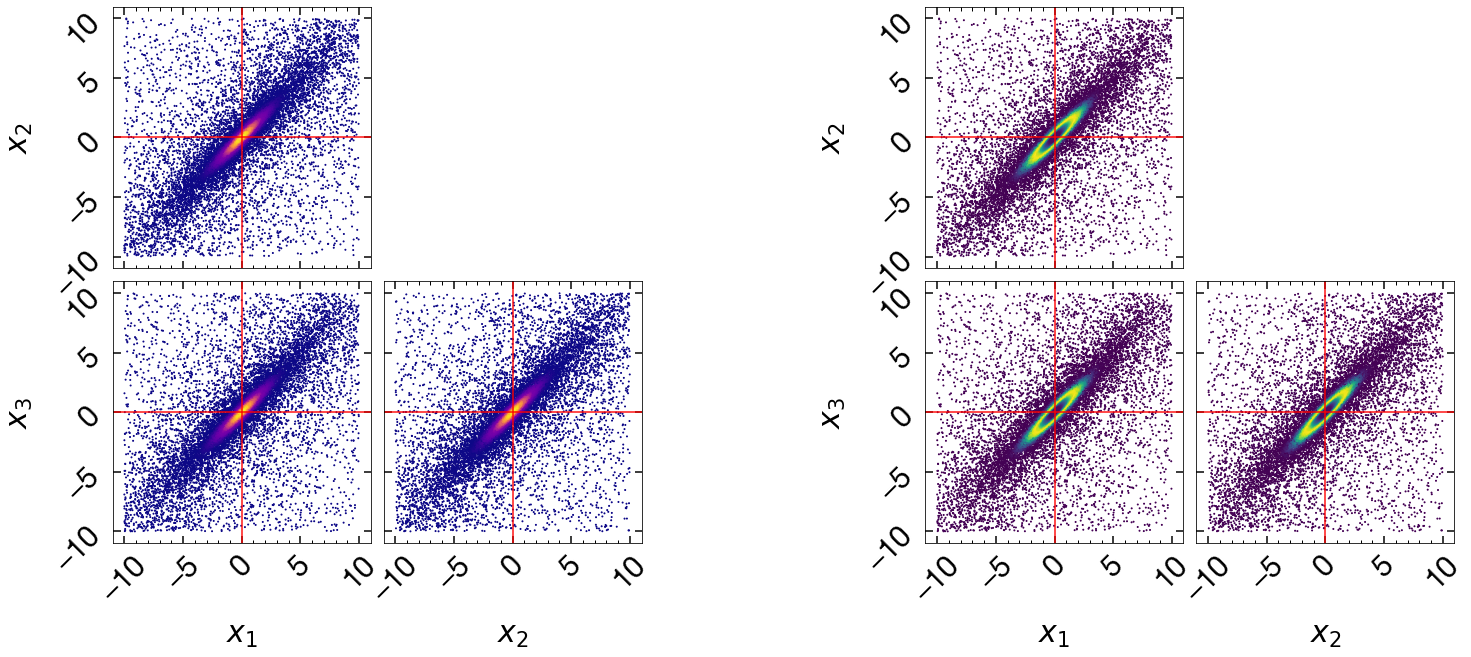

In [24]:
# initialize figure
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.reshape((2, 5))
[a.set_frame_on(False) for a in axes[:, 2]]
[a.set_xticks([]) for a in axes[:, 2]]
[a.set_yticks([]) for a in axes[:, 2]]

# plot initial run (left)
fg, ax = dyplot.cornerpoints(res, cmap='plasma', truths=[0., 0., 0.],
                             kde=False, fig=(fig, axes[:, :2]))

# plot extended run (right)
fg, ax = dyplot.cornerpoints(res2, cmap='viridis', truths=[0., 0., 0.],
                             kde=False, fig=(fig, axes[:, 3:]))

Just by looking at our projected samples, it is readily apparent that our extended run does a much better job of localizing the overall distribution. Let's try and get a better qualatative handle on this below by plotting the marginal 1-D and 2-D posteriors using `cornerplot`.

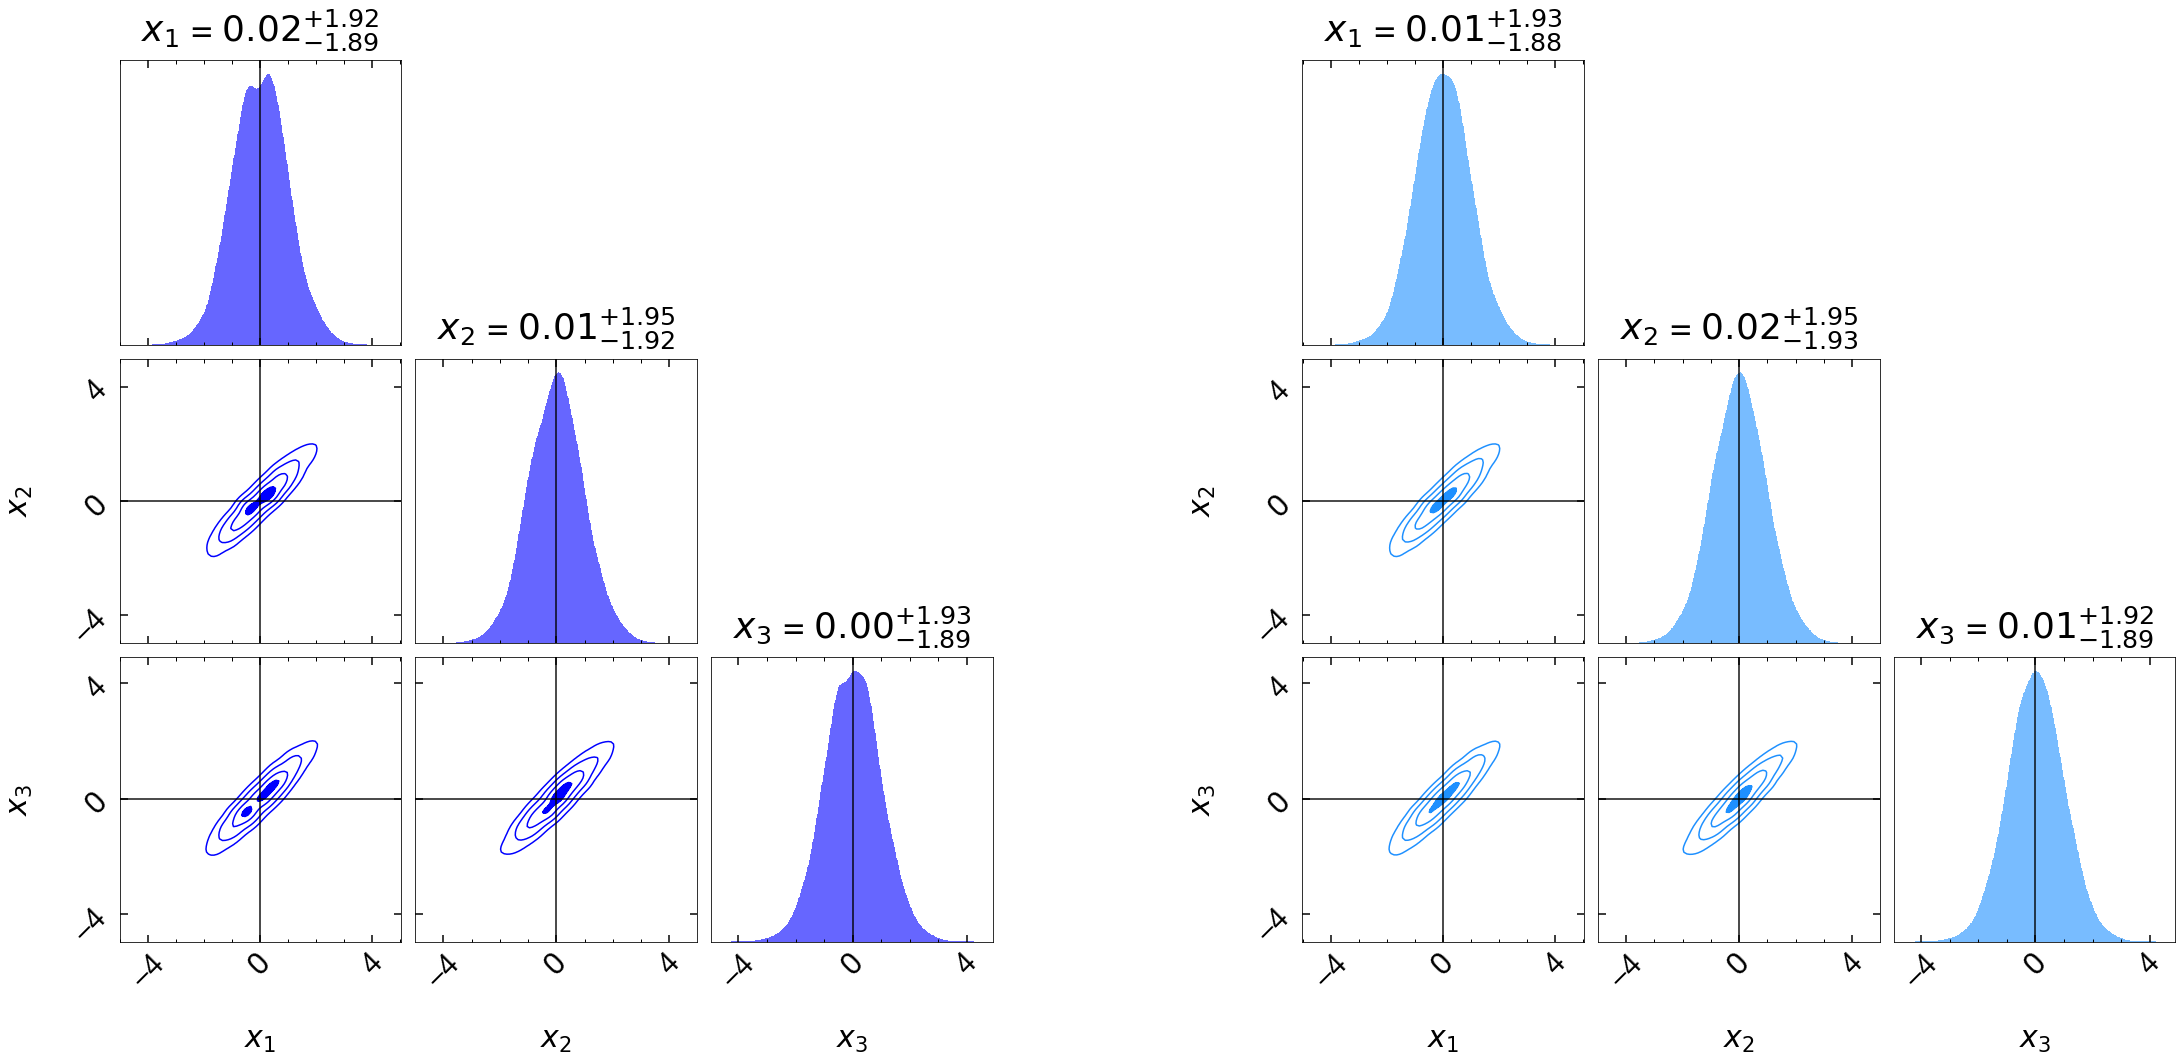

In [25]:
# initialize figure
fig, axes = plt.subplots(3, 7, figsize=(35, 15))
axes = axes.reshape((3, 7))
[a.set_frame_on(False) for a in axes[:, 3]]
[a.set_xticks([]) for a in axes[:, 3]]
[a.set_yticks([]) for a in axes[:, 3]]

# plot initial run (left)
fg, ax = dyplot.cornerplot(res, color='blue', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, :3]))

# plot extended run (right)
fg, ax = dyplot.cornerplot(res2, color='dodgerblue', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, max_n_ticks=3, fig=(fig, axes[:, 4:]))

Even though our original run (with 2x less samples) gave similar evidence estimates, it gives somewhat "noisier" estimates of the posterior than those from our extended run.

## Evolving Bounds

To visualize how we're sampling in nested "shells", we can look at the evolution of our bounding distributions in a given 2-D projection over the course of the run.

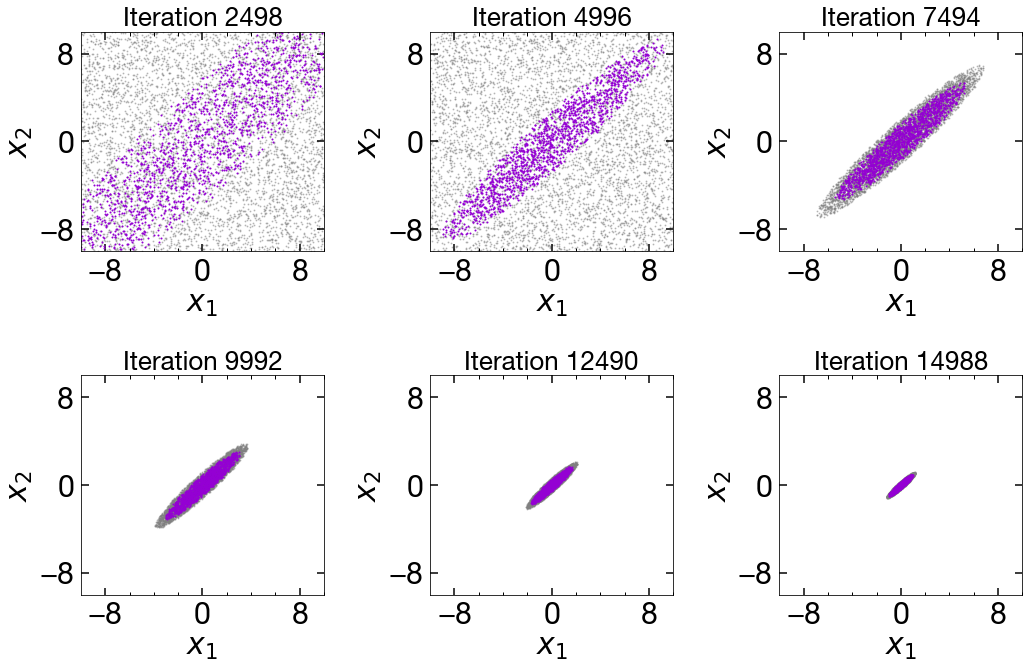

In [26]:
# initialize figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# plot 6 snapshots over the course of the run
for i, a in enumerate(axes.flatten()):
    it = int((i+1)*res2.niter/8.)
    # overplot the result onto each subplot
    temp = dyplot.boundplot(res2, dims=(0, 1), it=it, prior_transform=prior_transform, max_n_ticks=3,
                            show_live=True, span=[(-10, 10), (-10, 10)], fig=(fig, a))
    a.set_title('Iteration {0}'.format(it), fontsize=26)
fig.tight_layout()

Alternately, `cornerbound` generates corner plots for our proposals.

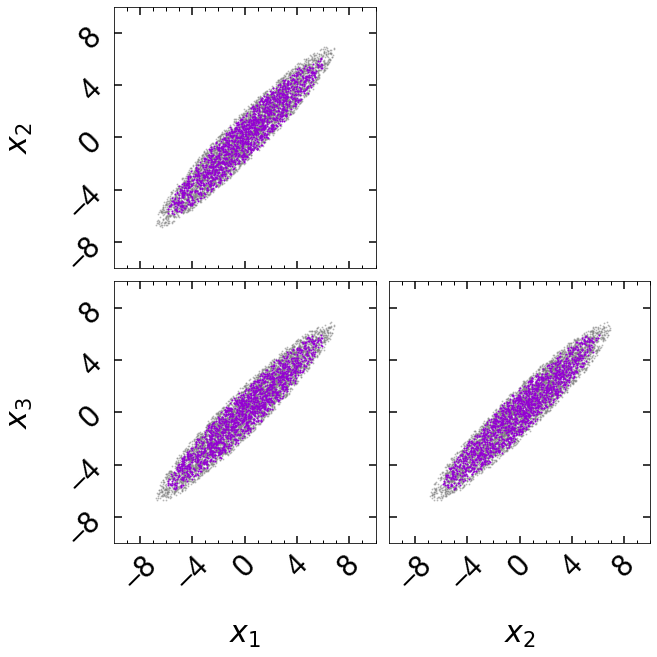

In [27]:
# initialize figure
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# plot proposals in corner format
fg, ax = dyplot.cornerbound(res2, it=7000, prior_transform=prior_transform, show_live=True, 
                            span=[(-10, 10), (-10, 10)], fig=(fig, axes))

We see that the default multi-ellipsoid proposals are able to adapt well to the target distribution over time, ensuring we continue to make efficient proposals without violating our uniform sampling assumptions. We can also see the impact our bootstrapping procedure has on the bounding ellipsoids: they always remain slightly larger than the set of live points. While this slightly decreases our efficiency, it helps ensure we do not "leave out" any likelihood during the course of the run.

# Summary

Nested sampling is a powerful and versatile approach for computing Bayesian evidences (with posterior estimates as a "free" by-product). Various nested sampling algorithms can be implemented using the `NestedSampler` "class" in `dynesty`, which allow for a variety of bounding and sampling methods. Sampling can be done implicitly (within `NestedSampler`) or explicitly (as a generator) depending on the degree of control users want over the outputs. Sampling can also be done in parallel using a user-supplied `pool`. Results can be accessed via the `results` property and can be visualized using several built-in plotting functions (via `plotting`).